In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zaber666/meld-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/meld-dataset


In [2]:
import os
import cv2
import pandas as pd
from tqdm import tqdm

# Config for each split
SPLITS = {
    'train': {
        'csv': '/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/train/train_sent_emo.csv',
        'video_dir': '/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/train/train_splits',
        'output_dir': '/kaggle/working/frames/train'
    },
    'val': {
        'csv': '/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/dev_sent_emo.csv',
        'video_dir': '/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/dev/dev_splits_complete',
        'output_dir': '/kaggle/working/frames/val'
    },
    'test': {
        'csv': '/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/test_sent_emo.csv',
        'video_dir': '/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/test/output_repeated_splits_test',
        'output_dir': '/kaggle/working/frames/test'
    }
}

FRAME_INTERVAL = 3  # seconds

# Main loop
for split_name, paths in SPLITS.items():
    print(f"\n[INFO] Extracting frames for split: {split_name}")
    
    df = pd.read_csv(paths['csv'])
    os.makedirs(paths['output_dir'], exist_ok=True)
    available_videos = os.listdir(paths['video_dir'])

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        dia_id = row['Dialogue_ID']
        utt_id = row['Utterance_ID']
        expected_name = f'dia{dia_id}_utt{utt_id}.mp4'

        # Match video file name
        if split_name == 'test':
            # Match by checking if filename ends with expected pattern
            matched_files = [f for f in available_videos if f.endswith(expected_name)]
            if not matched_files:
                continue
            video_name = matched_files[0]  # use first match
        else:
            if expected_name not in available_videos:
                continue
            video_name = expected_name

        video_path = os.path.join(paths['video_dir'], video_name)
        save_dir = os.path.join(paths['output_dir'], f"{dia_id}_{utt_id}")
        os.makedirs(save_dir, exist_ok=True)

        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_interval = int(fps * FRAME_INTERVAL) if fps and fps > 0 else 30  # fallback in case fps = 0
        frame_count = 0
        save_count = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            if frame_count % frame_interval == 0:
                frame_resized = cv2.resize(frame, (224, 224))
                frame_filename = f"frame_{save_count:03d}.jpg"
                cv2.imwrite(os.path.join(save_dir, frame_filename), frame_resized)
                save_count += 1
            frame_count += 1

        cap.release()

    print(f"[INFO] Done with {split_name} — processed {len(df)} entries (some skipped if no match).")



[INFO] Extracting frames for split: train


100%|██████████| 9989/9989 [30:22<00:00,  5.48it/s]  


[INFO] Done with train — processed 9989 entries (some skipped if no match).

[INFO] Extracting frames for split: val


100%|██████████| 1109/1109 [03:14<00:00,  5.69it/s]


[INFO] Done with val — processed 1109 entries (some skipped if no match).

[INFO] Extracting frames for split: test


  0%|          | 11/2610 [00:01<04:03, 10.65it/s][mov,mp4,m4a,3gp,3g2,mj2 @ 0x2598c180] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x2598c180] moov atom not found
  1%|          | 14/2610 [00:01<03:01, 14.29it/s][mov,mp4,m4a,3gp,3g2,mj2 @ 0x2598c180] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x2598c180] moov atom not found
  1%|          | 21/2610 [00:02<03:41, 11.67it/s][mov,mp4,m4a,3gp,3g2,mj2 @ 0x2598c180] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x2598c180] moov atom not found
  1%|          | 25/2610 [00:02<03:17, 13.08it/s][mov,mp4,m4a,3gp,3g2,mj2 @ 0x2598c180] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x2598c180] moov atom not found
  2%|▏         | 49/2610 [00:04<04:09, 10.28it/s][mov,mp4,m4a,3gp,3g2,mj2 @ 0x2598c180] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x2598c180] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x2598c180] moov atom not found
  2%|▏         | 55/2610 [00:04<03:19, 12.82it/s][mov,mp4,m4a,3gp,3g2,mj2 @ 0x2598c180] moov atom not foun

[INFO] Done with test — processed 2610 entries (some skipped if no match).


In [3]:
# Emotion and Sentiment label mapping
emotion2idx = {'neutral': 0, 'anger': 1, 'disgust': 2, 'sadness': 3, 'joy': 4, 'surprise': 5, 'fear': 6}
sentiment2idx = {'neutral': 0, 'positive': 1, 'negative': 2}


In [4]:
def build_label_dict(csv_path):
    df = pd.read_csv(csv_path)
    labels = {}
    valid_videos = set()

    print(f"[INFO] Loading labels from {csv_path} with {len(df)} entries")
    
    for _, row in df.iterrows():
        try:
            video_key = f"{row['Dialogue_ID']}_{row['Utterance_ID']}"
            labels[video_key + ".mp4"] = {
                'emotion': emotion2idx[row['Emotion'].lower()],
                'sentiment': sentiment2idx[row['Sentiment'].lower()]
            }
            valid_videos.add(video_key + ".mp4")
        except Exception as e:
            print(f"[ERROR] Failed for row: {row}\n{e}")
    
    print(f"[INFO] Built label dict with {len(labels)} entries")
    return labels


In [5]:
from torch.utils.data import Dataset
from PIL import Image
import torch
import torchvision.transforms as transforms
import glob

class FrameLevelMELDDataset(Dataset):
    def __init__(self, frames_root, label_dict, transform=None):
        self.samples = []
        self.transform = transform

        print(f"[INFO] Checking frames in: {frames_root}")
        found = 0

        for video_folder in os.listdir(frames_root):
            video_path = os.path.join(frames_root, video_folder)
            if not os.path.isdir(video_path):
                continue

            # Look for any frame_*.jpg
            frame_list = sorted(glob.glob(os.path.join(video_path, 'frame_*.jpg')))
            if not frame_list:
                print(f"[WARN] No frames found in {video_folder}")
                continue

            label_key = f"{video_folder}.mp4"
            if label_key in label_dict:
                # You can choose to use all frames or just the first one
                self.samples.append((frame_list[0], label_dict[label_key], video_folder))  # Added video_folder to the tuple
                found += 1
            else:
                print(f"[WARN] Label missing for {label_key}")

        print(f"[INFO] Loaded {found} valid frame-level samples")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        frame_path, labels, video_folder = self.samples[idx]  # Unpack the video_folder here
        image = Image.open(frame_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, (torch.tensor(labels['sentiment']), torch.tensor(labels['emotion']), video_folder)


In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load labels
train_labels = build_label_dict('/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/train/train_sent_emo.csv')
val_labels = build_label_dict('/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/dev_sent_emo.csv')
test_labels = build_label_dict('/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/test_sent_emo.csv')

# Datasets
train_dataset = FrameLevelMELDDataset('/kaggle/working/frames/train', train_labels, transform)
val_dataset = FrameLevelMELDDataset('/kaggle/working/frames/val', val_labels, transform)
test_dataset = FrameLevelMELDDataset('/kaggle/working/frames/test', test_labels, transform)

print(f"[INFO] Train dataset size: {len(train_dataset)}")
print(f"[INFO] Val dataset size: {len(val_dataset)}")
print(f"[INFO] Test dataset size: {len(test_dataset)}")


[INFO] Loading labels from /kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/train/train_sent_emo.csv with 9989 entries
[INFO] Built label dict with 9989 entries
[INFO] Loading labels from /kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/dev_sent_emo.csv with 1109 entries
[INFO] Built label dict with 1109 entries
[INFO] Loading labels from /kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/test_sent_emo.csv with 2610 entries
[INFO] Built label dict with 2610 entries
[INFO] Checking frames in: /kaggle/working/frames/train
[WARN] No frames found in 125_3
[INFO] Loaded 9988 valid frame-level samples
[INFO] Checking frames in: /kaggle/working/frames/val
[INFO] Loaded 1108 valid frame-level samples
[INFO] Checking frames in: /kaggle/working/frames/test
[WARN] No frames found in 236_0
[WARN] No frames found in 244_0
[WARN] No frames found in 60_0
[WARN] No frames found in 176_1
[WARN] No frames found in 12_8
[WARN] No frames found in 82_0
[WARN] No frames found in 15_3
[WARN] No frames found in 71_9
[WARN]

In [7]:
# DataLoaders
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)  # smaller batch size for videos
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MELD_VGG16(nn.Module):
    def __init__(self, feature_dim=100):
        super(MELD_VGG16, self).__init__()

        # Load the pretrained VGG-16 model
        vgg16 = models.vgg16_bn(pretrained=True)
        
        # Use only the feature extractor (convolutional layers)
        self.features = vgg16.features

        # Freeze VGG layers if you don't want to train them
        # for param in self.features.parameters():
        #     param.requires_grad = False

        # Replace classifier to output our feature representation
        self.avgpool = vgg16.avgpool
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512 * 7 * 7, feature_dim)
        self.relu_fc = nn.LeakyReLU(0.1)

        # Output heads
        self.sentiment_head = nn.Linear(feature_dim, 3)  # Sentiment: 3 classes
        self.emotion_head = nn.Linear(feature_dim, 7)    # Emotion: 7 classes

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        features = self.relu_fc(self.fc1(x))

        sentiment_logits = self.sentiment_head(features)
        emotion_logits = self.emotion_head(features)

        return sentiment_logits, emotion_logits

# Instantiate model and move to GPU
model = MELD_VGG16().to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:02<00:00, 231MB/s] 


In [9]:
import torch.nn as nn
import torch.optim as optim

# Define loss functions for both outputs
sentiment_criterion = nn.CrossEntropyLoss()
emotion_criterion = nn.CrossEntropyLoss()

sentiment_criterion = sentiment_criterion.to(device)
emotion_criterion = emotion_criterion.to(device)

# Optimizer (unchanged)
learning_rate = 0.001
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-7

optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1, beta2), eps=epsilon)


In [10]:
from sklearn.metrics import accuracy_score
from collections import defaultdict, Counter
from tqdm import tqdm
import numpy as np
import torch

def aggregate_predictions(preds_dict):
    final_preds = {}
    for video, preds in preds_dict.items():
        votes = Counter(preds)
        final_preds[video] = votes.most_common(1)[0][0]
    return final_preds

train_losses, val_losses = [], []
train_sent_losses, val_sent_losses = [], []
train_emo_losses, val_emo_losses = [], []
train_sent_accs, val_sent_accs = [], []
train_emo_accs, val_emo_accs = [], []

num_epochs = 50
patience = 5
min_delta = 0.001
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    print(f"\n===== Epoch {epoch+1}/{num_epochs} =====")

    # ---------- Training ----------
    model.train()
    total_train_loss, sent_loss_sum, emo_loss_sum = 0.0, 0.0, 0.0
    train_sent_preds, train_emo_preds = [], []
    train_sent_labels, train_emo_labels = [], []

    for images, (sentiment_labels, emotion_labels, video_folder) in tqdm(train_loader, desc=f"Train"):
        images = images.to(device)
        sentiment_labels = sentiment_labels.to(device)
        emotion_labels = emotion_labels.to(device)

        optimizer.zero_grad()
        sent_out, emo_out = model(images)

        loss_sent = sentiment_criterion(sent_out, sentiment_labels)
        loss_emo = emotion_criterion(emo_out, emotion_labels)
        loss = loss_sent + loss_emo
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        sent_loss_sum += loss_sent.item()
        emo_loss_sum += loss_emo.item()

        train_sent_preds.extend(sent_out.argmax(dim=1).cpu().numpy())
        train_emo_preds.extend(emo_out.argmax(dim=1).cpu().numpy())
        train_sent_labels.extend(sentiment_labels.cpu().numpy())
        train_emo_labels.extend(emotion_labels.cpu().numpy())

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_sent_loss = sent_loss_sum / len(train_loader)
    avg_train_emo_loss = emo_loss_sum / len(train_loader)
    train_sent_acc = accuracy_score(train_sent_labels, train_sent_preds)
    train_emo_acc = accuracy_score(train_emo_labels, train_emo_preds)

    train_losses.append(avg_train_loss)
    train_sent_losses.append(avg_train_sent_loss)
    train_emo_losses.append(avg_train_emo_loss)
    train_sent_accs.append(train_sent_acc)
    train_emo_accs.append(train_emo_acc)

    # ---------- Validation ----------
    model.eval()
    total_val_loss, sent_val_loss_sum, emo_val_loss_sum = 0.0, 0.0, 0.0
    val_sent_preds_dict = defaultdict(list)
    val_emo_preds_dict = defaultdict(list)
    val_sent_labels_dict = {}
    val_emo_labels_dict = {}

    with torch.no_grad():
        for images, (sentiment_labels, emotion_labels, video_folder) in tqdm(val_loader, desc="Val"):
            images = images.to(device)
            sentiment_labels = sentiment_labels.to(device)
            emotion_labels = emotion_labels.to(device)

            sent_out, emo_out = model(images)
            loss_sent = sentiment_criterion(sent_out, sentiment_labels)
            loss_emo = emotion_criterion(emo_out, emotion_labels)
            loss = loss_sent + loss_emo

            total_val_loss += loss.item()
            sent_val_loss_sum += loss_sent.item()
            emo_val_loss_sum += loss_emo.item()

            pred_sent = sent_out.argmax(dim=1).cpu().numpy()
            pred_emo = emo_out.argmax(dim=1).cpu().numpy()
            sent_labels_np = sentiment_labels.cpu().numpy()
            emo_labels_np = emotion_labels.cpu().numpy()

            for i, vid in enumerate(video_folder):
                val_sent_preds_dict[vid].append(pred_sent[i])
                val_emo_preds_dict[vid].append(pred_emo[i])
                val_sent_labels_dict[vid] = sent_labels_np[i]
                val_emo_labels_dict[vid] = emo_labels_np[i]

    # Aggregate video-wise predictions
    agg_sent_preds = aggregate_predictions(val_sent_preds_dict)
    agg_emo_preds = aggregate_predictions(val_emo_preds_dict)

    agg_sent_labels = [val_sent_labels_dict[vid] for vid in agg_sent_preds]
    agg_emo_labels = [val_emo_labels_dict[vid] for vid in agg_emo_preds]
    agg_sent_preds_list = [agg_sent_preds[vid] for vid in agg_sent_preds]
    agg_emo_preds_list = [agg_emo_preds[vid] for vid in agg_emo_preds]

    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_sent_loss = sent_val_loss_sum / len(val_loader)
    avg_val_emo_loss = emo_val_loss_sum / len(val_loader)
    val_sent_acc = accuracy_score(agg_sent_labels, agg_sent_preds_list)
    val_emo_acc = accuracy_score(agg_emo_labels, agg_emo_preds_list)

    val_losses.append(avg_val_loss)
    val_sent_losses.append(avg_val_sent_loss)
    val_emo_losses.append(avg_val_emo_loss)
    val_sent_accs.append(val_sent_acc)
    val_emo_accs.append(val_emo_acc)

    # ---------- Early Stopping ----------
    if avg_val_loss + min_delta < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'Adam_weights.pth')
        print(f"[INFO] Model saved.")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"[EARLY STOPPING] No improvement for {patience} epochs.")
            break

    # ---------- Logging ----------
    print(f"Train Loss: {avg_train_loss:.4f} | Sent Loss: {avg_train_sent_loss:.4f} | Emo Loss: {avg_train_emo_loss:.4f}")
    print(f"Val Loss:   {avg_val_loss:.4f} | Sent Loss: {avg_val_sent_loss:.4f} | Emo Loss: {avg_val_emo_loss:.4f}")
    print(f"Sentiment Acc: Train={train_sent_acc:.4f}, Val={val_sent_acc:.4f}")
    print(f"Emotion Acc:   Train={train_emo_acc:.4f}, Val={val_emo_acc:.4f}")



===== Epoch 1/50 =====


Val: 100%|██████████| 277/277 [00:10<00:00, 27.65it/s]


[INFO] Model saved.
Train Loss: 2.6446 | Sent Loss: 1.0712 | Emo Loss: 1.5734
Val Loss:   2.7296 | Sent Loss: 1.0690 | Emo Loss: 1.6606
Sentiment Acc: Train=0.4587, Val=0.4233
Emotion Acc:   Train=0.4676, Val=0.4233

===== Epoch 2/50 =====


Val: 100%|██████████| 277/277 [00:10<00:00, 27.61it/s]


[INFO] Model saved.
Train Loss: 2.6025 | Sent Loss: 1.0579 | Emo Loss: 1.5446
Val Loss:   2.7237 | Sent Loss: 1.0661 | Emo Loss: 1.6576
Sentiment Acc: Train=0.4679, Val=0.4323
Emotion Acc:   Train=0.4715, Val=0.4233

===== Epoch 3/50 =====


Val: 100%|██████████| 277/277 [00:09<00:00, 28.03it/s]


Train Loss: 2.5973 | Sent Loss: 1.0560 | Emo Loss: 1.5413
Val Loss:   2.9372 | Sent Loss: 1.1657 | Emo Loss: 1.7715
Sentiment Acc: Train=0.4686, Val=0.4233
Emotion Acc:   Train=0.4715, Val=0.4233

===== Epoch 4/50 =====


Val: 100%|██████████| 277/277 [00:09<00:00, 27.97it/s]


Train Loss: 2.5937 | Sent Loss: 1.0534 | Emo Loss: 1.5403
Val Loss:   2.7277 | Sent Loss: 1.0713 | Emo Loss: 1.6564
Sentiment Acc: Train=0.4683, Val=0.4242
Emotion Acc:   Train=0.4715, Val=0.4233

===== Epoch 5/50 =====


Val: 100%|██████████| 277/277 [00:09<00:00, 27.85it/s]


Train Loss: 2.5833 | Sent Loss: 1.0504 | Emo Loss: 1.5329
Val Loss:   2.7334 | Sent Loss: 1.0776 | Emo Loss: 1.6558
Sentiment Acc: Train=0.4694, Val=0.4242
Emotion Acc:   Train=0.4714, Val=0.4233

===== Epoch 6/50 =====


Val: 100%|██████████| 277/277 [00:09<00:00, 28.09it/s]


[INFO] Model saved.
Train Loss: 2.5908 | Sent Loss: 1.0534 | Emo Loss: 1.5375
Val Loss:   2.7008 | Sent Loss: 1.0650 | Emo Loss: 1.6358
Sentiment Acc: Train=0.4693, Val=0.4233
Emotion Acc:   Train=0.4715, Val=0.4233

===== Epoch 7/50 =====


Val: 100%|██████████| 277/277 [00:09<00:00, 27.83it/s]


Train Loss: 2.5869 | Sent Loss: 1.0525 | Emo Loss: 1.5344
Val Loss:   2.7071 | Sent Loss: 1.0666 | Emo Loss: 1.6405
Sentiment Acc: Train=0.4714, Val=0.4233
Emotion Acc:   Train=0.4714, Val=0.4233

===== Epoch 8/50 =====


Val: 100%|██████████| 277/277 [00:09<00:00, 27.91it/s]


Train Loss: 2.5762 | Sent Loss: 1.0458 | Emo Loss: 1.5303
Val Loss:   2.7365 | Sent Loss: 1.0691 | Emo Loss: 1.6673
Sentiment Acc: Train=0.4778, Val=0.4215
Emotion Acc:   Train=0.4715, Val=0.4233

===== Epoch 9/50 =====


Val: 100%|██████████| 277/277 [00:09<00:00, 27.93it/s]


Train Loss: 2.5704 | Sent Loss: 1.0431 | Emo Loss: 1.5274
Val Loss:   2.7647 | Sent Loss: 1.0962 | Emo Loss: 1.6685
Sentiment Acc: Train=0.4743, Val=0.4224
Emotion Acc:   Train=0.4717, Val=0.4242

===== Epoch 10/50 =====


Val: 100%|██████████| 277/277 [00:09<00:00, 27.83it/s]


Train Loss: 2.5637 | Sent Loss: 1.0396 | Emo Loss: 1.5241
Val Loss:   2.7048 | Sent Loss: 1.0673 | Emo Loss: 1.6375
Sentiment Acc: Train=0.4784, Val=0.4043
Emotion Acc:   Train=0.4712, Val=0.4233

===== Epoch 11/50 =====


Val: 100%|██████████| 277/277 [00:09<00:00, 28.04it/s]

[EARLY STOPPING] No improvement for 5 epochs.


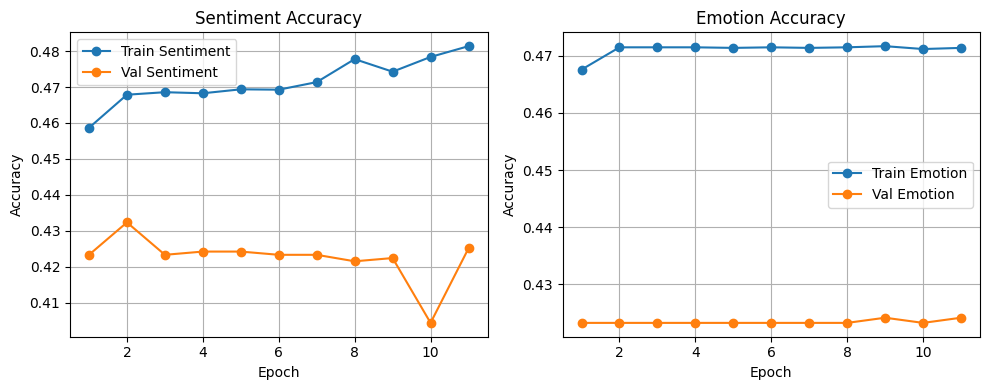

In [11]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_sent_accs) + 1)
plt.figure(figsize=(10, 4))

# Sentiment accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_sent_accs, label="Train Sentiment", marker='o')
plt.plot(epochs, val_sent_accs, label="Val Sentiment", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Sentiment Accuracy")
plt.legend()
plt.grid()

# Emotion accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_emo_accs, label="Train Emotion", marker='o')
plt.plot(epochs, val_emo_accs, label="Val Emotion", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Emotion Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


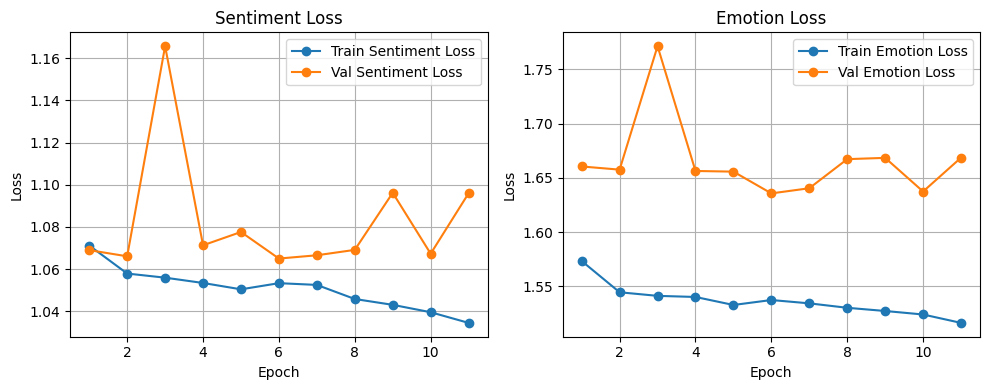

In [12]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 4))

# Sentiment loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_sent_losses, label="Train Sentiment Loss", marker='o')
plt.plot(epochs, val_sent_losses, label="Val Sentiment Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Sentiment Loss")
plt.legend()
plt.grid()

# Emotion loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_emo_losses, label="Train Emotion Loss", marker='o')
plt.plot(epochs, val_emo_losses, label="Val Emotion Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Emotion Loss")
plt.legend()
plt.grid()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [16]:
import torch.nn.functional as F
import numpy as np
from collections import defaultdict
from sklearn.metrics import classification_report

model.eval()

video_sent_logits = defaultdict(list)
video_emo_logits = defaultdict(list)
video_sent_labels = {}
video_emo_labels = {}

with torch.no_grad():
    for images, (sentiment_labels, emotion_labels, video_folder) in test_loader:
        images = images.to(device)
        sentiment_labels = sentiment_labels.to(device)
        emotion_labels = emotion_labels.to(device)

        sent_out, emo_out = model(images)

        for idx, video in enumerate(video_folder):
            video_sent_logits[video].append(sent_out[idx].cpu())
            video_emo_logits[video].append(emo_out[idx].cpu())

            if video not in video_sent_labels:
                video_sent_labels[video] = sentiment_labels[idx].item()
                video_emo_labels[video] = emotion_labels[idx].item()

# Final containers
test_sent_preds, test_sent_labels = [], []
test_emo_preds, test_emo_labels = [], []
sent_probs, emo_probs = [], []

for video in video_sent_logits:
    sent_logit_stack = torch.stack(video_sent_logits[video])
    emo_logit_stack = torch.stack(video_emo_logits[video])

    avg_sent_probs = F.softmax(sent_logit_stack, dim=1).mean(dim=0)
    avg_emo_probs = F.softmax(emo_logit_stack, dim=1).mean(dim=0)

    sent_probs.append(avg_sent_probs.numpy())
    emo_probs.append(avg_emo_probs.numpy())

    test_sent_preds.append(torch.argmax(avg_sent_probs).item())
    test_emo_preds.append(torch.argmax(avg_emo_probs).item())

    test_sent_labels.append(video_sent_labels[video])
    test_emo_labels.append(video_emo_labels[video])

print("\nSentiment Classification Report:\n", classification_report(test_sent_labels, test_sent_preds))
print("\nEmotion Classification Report:\n", classification_report(test_emo_labels, test_emo_preds))



Sentiment Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.92      0.64       771
           1       1.00      0.00      0.01       330
           2       0.36      0.10      0.15       494

    accuracy                           0.48      1595
   macro avg       0.62      0.34      0.26      1595
weighted avg       0.55      0.48      0.36      1595


Emotion Classification Report:
               precision    recall  f1-score   support

           0       0.48      1.00      0.65       771
           1       0.00      0.00      0.00       214
           2       0.00      0.00      0.00        35
           3       0.00      0.00      0.00       118
           4       0.00      0.00      0.00       260
           5       0.00      0.00      0.00       167
           6       0.00      0.00      0.00        30

    accuracy                           0.48      1595
   macro avg       0.07      0.14      0.09      1595
weighted 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve

# Sentiment scores
sent_accuracy = accuracy_score(test_sent_labels, test_sent_preds)
sent_precision = precision_score(test_sent_labels, test_sent_preds, average='weighted')
sent_recall = recall_score(test_sent_labels, test_sent_preds, average='weighted')
sent_f1 = f1_score(test_sent_labels, test_sent_preds, average='weighted')
sent_conf_matrix = confusion_matrix(test_sent_labels, test_sent_preds)

# Emotion scores
emo_accuracy = accuracy_score(test_emo_labels, test_emo_preds)
emo_precision = precision_score(test_emo_labels, test_emo_preds, average='weighted')
emo_recall = recall_score(test_emo_labels, test_emo_preds, average='weighted')
emo_f1 = f1_score(test_emo_labels, test_emo_preds, average='weighted')
emo_conf_matrix = confusion_matrix(test_emo_labels, test_emo_preds)

# Print
print("\n Sentiment Metrics")
print(f"Accuracy:  {sent_accuracy:.4f}")
print(f"Precision: {sent_precision:.4f}")
print(f"Recall:    {sent_recall:.4f}")
print(f"F1 Score:  {sent_f1:.4f}")

print("\n Emotion Metrics")
print(f"Accuracy:  {emo_accuracy:.4f}")
print(f"Precision: {emo_precision:.4f}")
print(f"Recall:    {emo_recall:.4f}")
print(f"F1 Score:  {emo_f1:.4f}")



 Sentiment Metrics
Accuracy:  0.4752
Precision: 0.5533
Recall:    0.4752
F1 Score:  0.3550

 Emotion Metrics
Accuracy:  0.4834
Precision: 0.2337
Recall:    0.4834
F1 Score:  0.3150


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


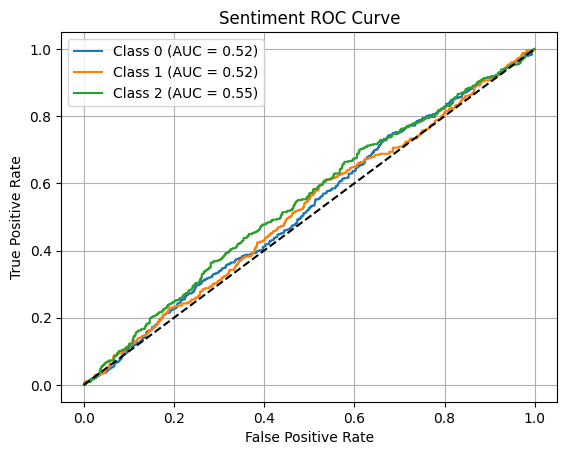

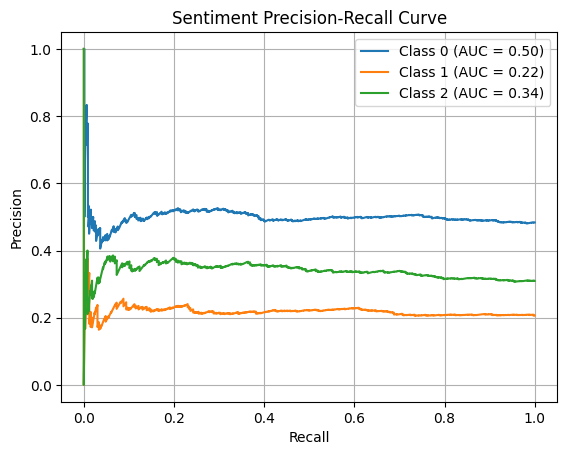

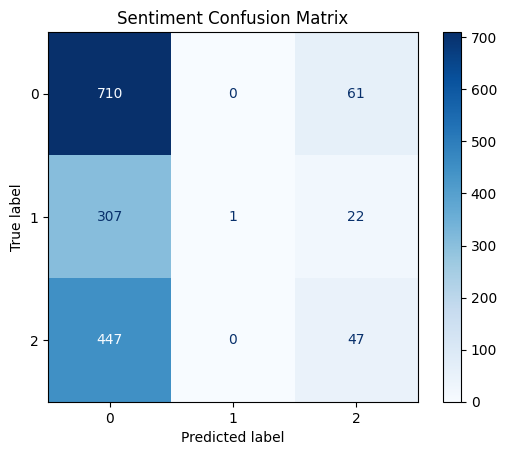

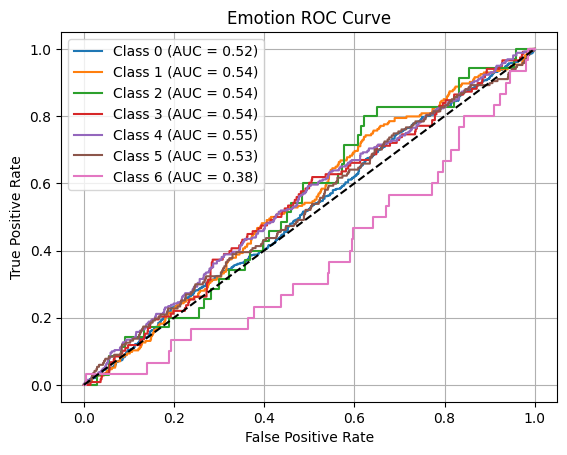

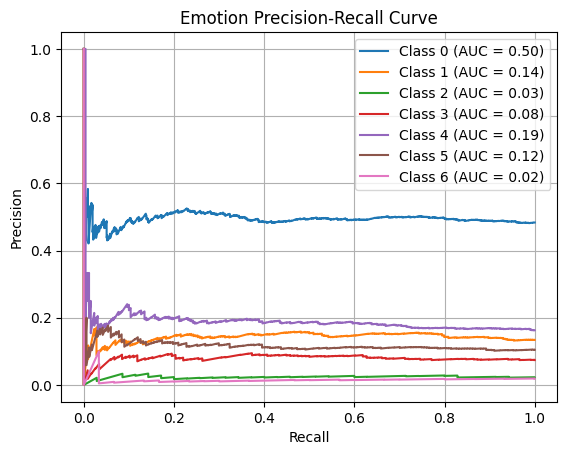

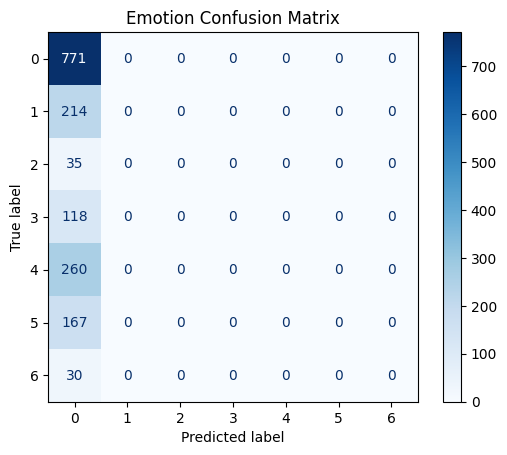

In [19]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import numpy as np

# Convert to NumPy arrays
test_sent_labels = np.array(test_sent_labels)
test_emo_labels = np.array(test_emo_labels)
sent_probs = np.vstack(sent_probs)  # (N, num_classes)
emo_probs = np.vstack(emo_probs)

n_sent_classes = sent_probs.shape[1]
n_emo_classes = emo_probs.shape[1]

test_sent_labels_bin = label_binarize(test_sent_labels, classes=range(n_sent_classes))
test_emo_labels_bin = label_binarize(test_emo_labels, classes=range(n_emo_classes))

def plot_multiclass_roc(true_bin, probs, n_classes, title):
    plt.figure()
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(true_bin[:, i], probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{title} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_multiclass_prc(true_bin, probs, n_classes, title):
    plt.figure()
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(true_bin[:, i], probs[:, i])
        pr_auc = average_precision_score(true_bin[:, i], probs[:, i])
        plt.plot(recall, precision, label=f'Class {i} (AUC = {pr_auc:.2f})')
    plt.title(f'{title} Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_conf_matrix(true_labels, preds, title):
    labels = sorted(set(true_labels) | set(preds))
    cm = confusion_matrix(true_labels, preds, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'{title} Confusion Matrix')
    plt.grid(False)
    plt.show()

# ---- Plotting ----
plot_multiclass_roc(test_sent_labels_bin, sent_probs, n_sent_classes, 'Sentiment')
plot_multiclass_prc(test_sent_labels_bin, sent_probs, n_sent_classes, 'Sentiment')
plot_conf_matrix(test_sent_labels, test_sent_preds, 'Sentiment')

plot_multiclass_roc(test_emo_labels_bin, emo_probs, n_emo_classes, 'Emotion')
plot_multiclass_prc(test_emo_labels_bin, emo_probs, n_emo_classes, 'Emotion')
plot_conf_matrix(test_emo_labels, test_emo_preds, 'Emotion')
